In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, COLORMAPS
from collections import Counter
from matplotlib.lines import Line2D
from aging.organization.dataframes import load_male_long_df, load_female_long_df, DF_PATHS
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
format_plots()

In [5]:
cmm = COLORMAPS.ont_male
cmf = COLORMAPS.ont_female
m_df = load_male_long_df(average_weeks=True, merge_size=False, merge_ages=True, df_path=DF_PATHS.usage_male).groupby(['age','mouse']).mean()
f_df = load_female_long_df(average_weeks=True, merge_size=False, filter_female=True, merge_ages=True, df_path=DF_PATHS.usage_female).groupby(['age','mouse']).mean()
m_df['sex'] = 'm'
m_df.set_index('sex', inplace=True, append=True)
f_df['sex'] = 'f'
f_df.set_index('sex', inplace=True, append=True)

# Combine male and female data into a single DataFrame
combined_df = pd.concat([m_df, f_df])

In [6]:
# avarage per age or session
avg_m_df = m_df.groupby(['age']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
avg_m_norm = mm_norm_col(avg_m_df)
avg_f_norm = mm_norm_col(avg_f_df)

In [7]:
# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)


# sort syllable order by the average
syll_sort_f = (
    avg_f_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [8]:
ba = m_df[syll_sort_m]

In [9]:
ind1 = 4
ind2 = 16
b1 = ba.loc[(ind1, "M1_04")].to_numpy().squeeze()
b2 = ba.loc[(ind1, "M1_03")].to_numpy().squeeze()

b3 = ba.loc[(ind2, "M1_04")].to_numpy().squeeze()
b4 = ba.loc[(ind2, "M1_03")].to_numpy().squeeze()

syll_df = pd.concat(
    [
        pd.DataFrame(
            dict(
                diff=b1 - b2,
                sort_diff=np.sort(b1 - b2),
                m1=b1,
                m2=b2,
                age=ind1,
                ord=np.arange(len(b1))[np.argsort(b1 - b2)],
            )
        ),
        pd.DataFrame(
            dict(
                diff=b3 - b4,
                sort_diff=np.sort(b3 - b4),
                m1=b3,
                m2=b4,
                age=ind2,
                ord=np.arange(len(b3))[np.argsort(b3 - b4)],
            )
        ),
    ]
).reset_index()
syll_df = syll_df.rename(columns={"index": "syllable"})

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


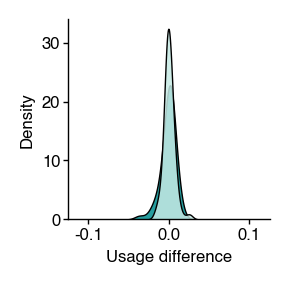

In [10]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
ax = sns.kdeplot(data=syll_df, x='diff', hue='age', bw_adjust=1.5, palette=cmm, fill=True, edgecolor='k', linewidth=0.5, alpha=0.85, legend=False)
ax.set(xlabel="Usage difference", xlim=(-0.125, 0.125))
sns.despine()

In [11]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '2indv_diff_dist_longv2_male.pdf')

In [12]:
idx = np.argsort(b2 + b4)[::-1]

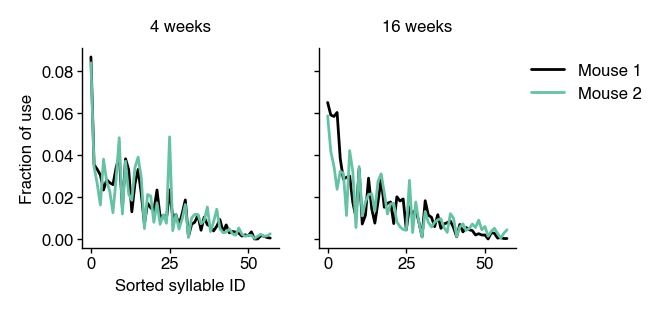

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(2.8, 1.3), sharey=True)
ax[0].plot(b2[idx], label="Mouse 1", c='k')
ax[0].plot(b1[idx], label="Mouse 2", c='#66c2a4')
ax[1].plot(b4[idx], label="Mouse 1", c='k')
ax[1].plot(b3[idx], label="Mouse 2", c='#66c2a4')
ax[1].set(title=f"{ind2} weeks")
ax[0].set(xlabel="Sorted syllable ID", ylabel="Fraction of use", title=f"{ind1} weeks")
legend(ax[1])
sns.despine()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '2indv_example_line_longv2_male.pdf')

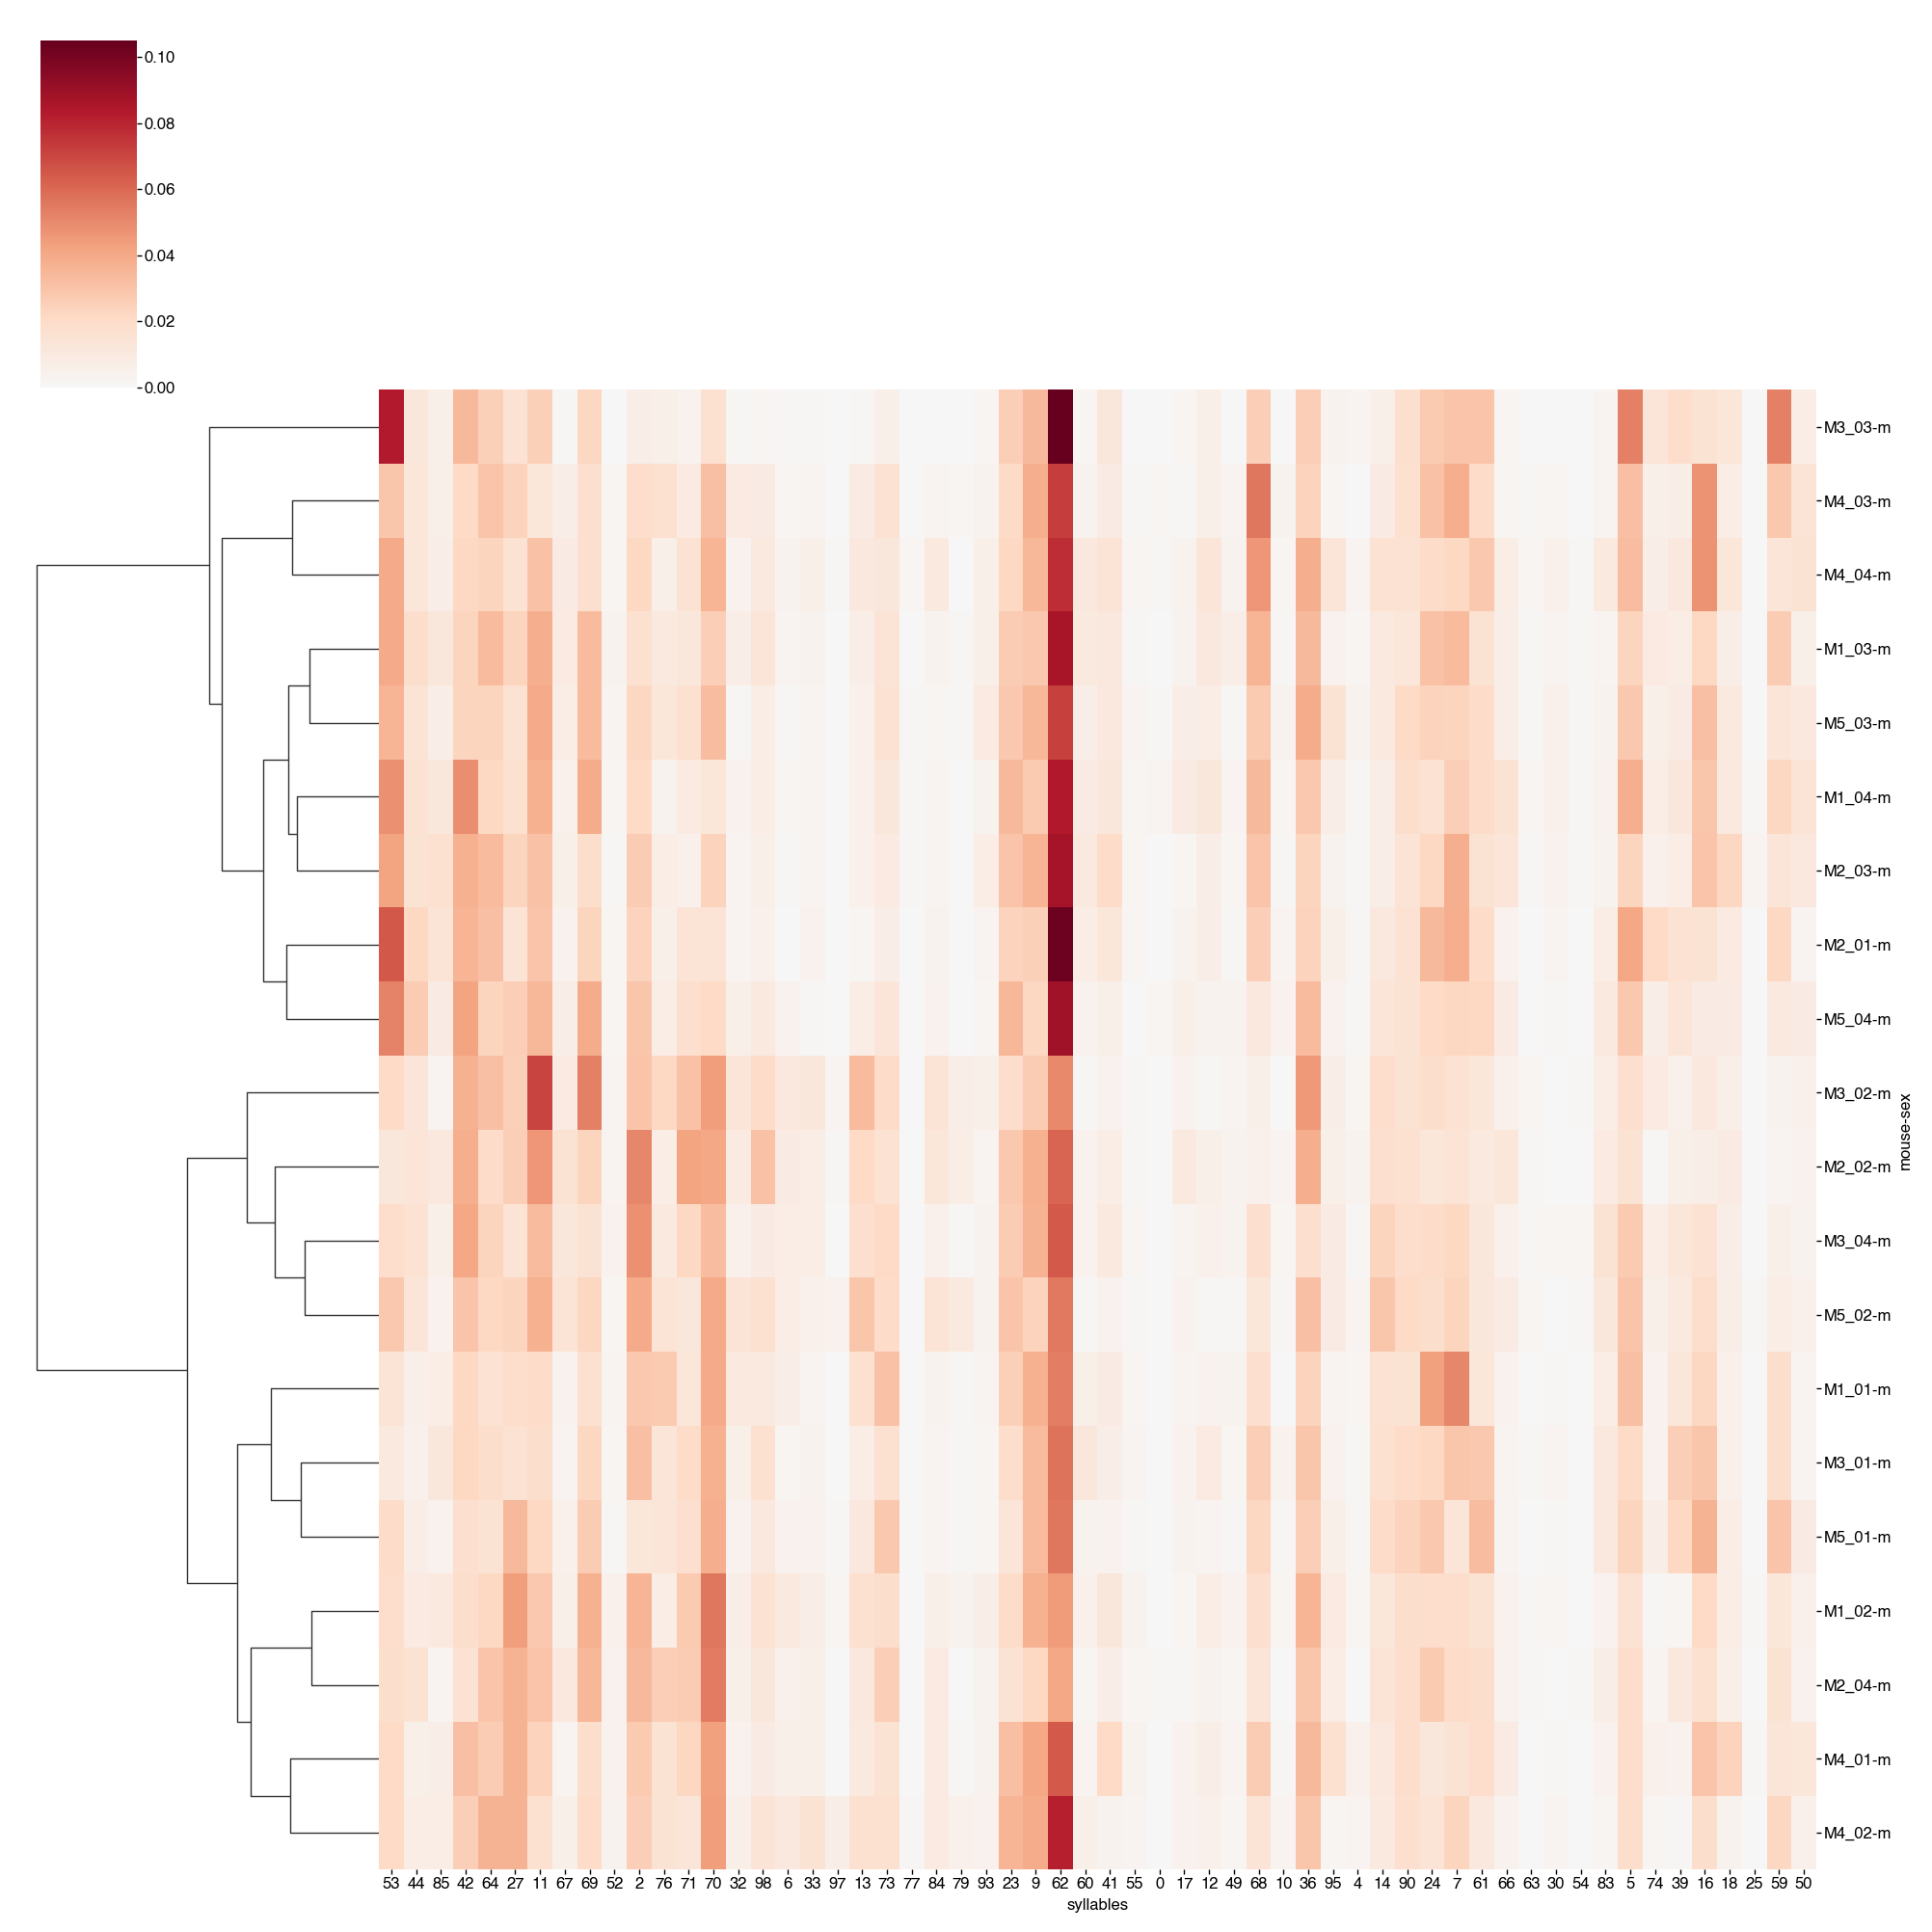

In [15]:
# sort by similarity of mice in the first age
g = sns.clustermap(ba.loc[ind1], cmap='RdBu_r', col_cluster=False, center=0,  metric='euclidean', method='ward')
row_order = g.dendrogram_row.dendrogram['leaves']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


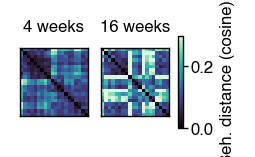

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(1.2, 0.6), sharey=True)
age = syll_df['age'].min()
out = squareform(pdist(ba.loc[ind1].iloc[row_order], metric='cosine'))
ax[0].imshow(out, vmin=0.0, vmax=0.3, cmap='mako')
ax[0].set(xticks=[], yticks=[],title=f"{age} weeks")
age = syll_df['age'].max()
out = squareform(pdist(ba.loc[ind2].iloc[row_order], metric='cosine'))
im=ax[1].imshow(out,vmin=0.0, vmax=0.3, cmap='mako')
ax[1].set(xticks=[], yticks=[],title=f"{age} weeks")
fig.colorbar(im, ax=ax, label="Beh. distance (cosine)")
legend(ax[1])

In [17]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '2indv_example_dist_longv2_male_cosine.pdf')

In [18]:
## for females

In [19]:
ba = f_df[syll_sort_f]

In [20]:
ind1 = 4
ind2 = 16
b1 = ba.loc[(ind1, "F1_01")].to_numpy().squeeze()
b2 = ba.loc[(ind1, "F1_02")].to_numpy().squeeze()

b3 = ba.loc[(ind2, "F1_01")].to_numpy().squeeze()
b4 = ba.loc[(ind2, "F1_02")].to_numpy().squeeze()

syll_df = pd.concat(
    [
        pd.DataFrame(
            dict(
                diff=b1 - b2,
                sort_diff=np.sort(b1 - b2),
                m1=b1,
                m2=b2,
                age=ind1,
                ord=np.arange(len(b1))[np.argsort(b1 - b2)],
            )
        ),
        pd.DataFrame(
            dict(
                diff=b3 - b4,
                sort_diff=np.sort(b3 - b4),
                m1=b3,
                m2=b4,
                age=ind2,
                ord=np.arange(len(b3))[np.argsort(b3 - b4)],
            )
        ),
    ]
).reset_index()
syll_df = syll_df.rename(columns={"index": "syllable"})

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


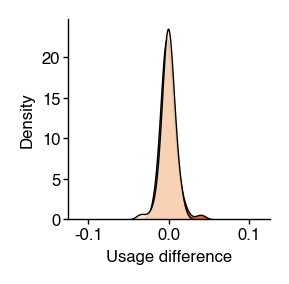

In [21]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
ax = sns.kdeplot(data=syll_df, x='diff', hue='age', bw_adjust=1.5, palette=cmf, fill=True, edgecolor='k', linewidth=0.5, alpha=0.85, legend=False)
ax.set(xlabel="Usage difference", xlim=(-0.125, 0.125))
sns.despine()

In [22]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '2indv_diff_dist_longv2_female.pdf')

In [23]:
idx = np.argsort(b2 + b4)[::-1]

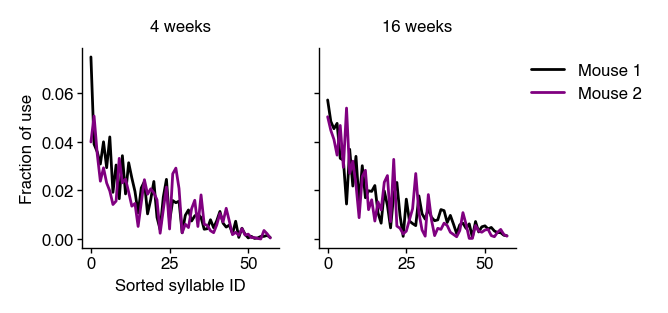

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(2.8, 1.3), sharey=True)
ax[0].plot(b2[idx], label="Mouse 1", c='k')
ax[0].plot(b1[idx], label="Mouse 2", c='purple')
ax[1].plot(b4[idx], label="Mouse 1", c='k')
ax[1].plot(b3[idx], label="Mouse 2", c='purple')
ax[1].set(title=f"{ind2} weeks")
ax[0].set(xlabel="Sorted syllable ID", ylabel="Fraction of use", title=f"{ind1} weeks")
legend(ax[1])
sns.despine()

In [25]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '2indv_example_line_longv2_female.pdf')

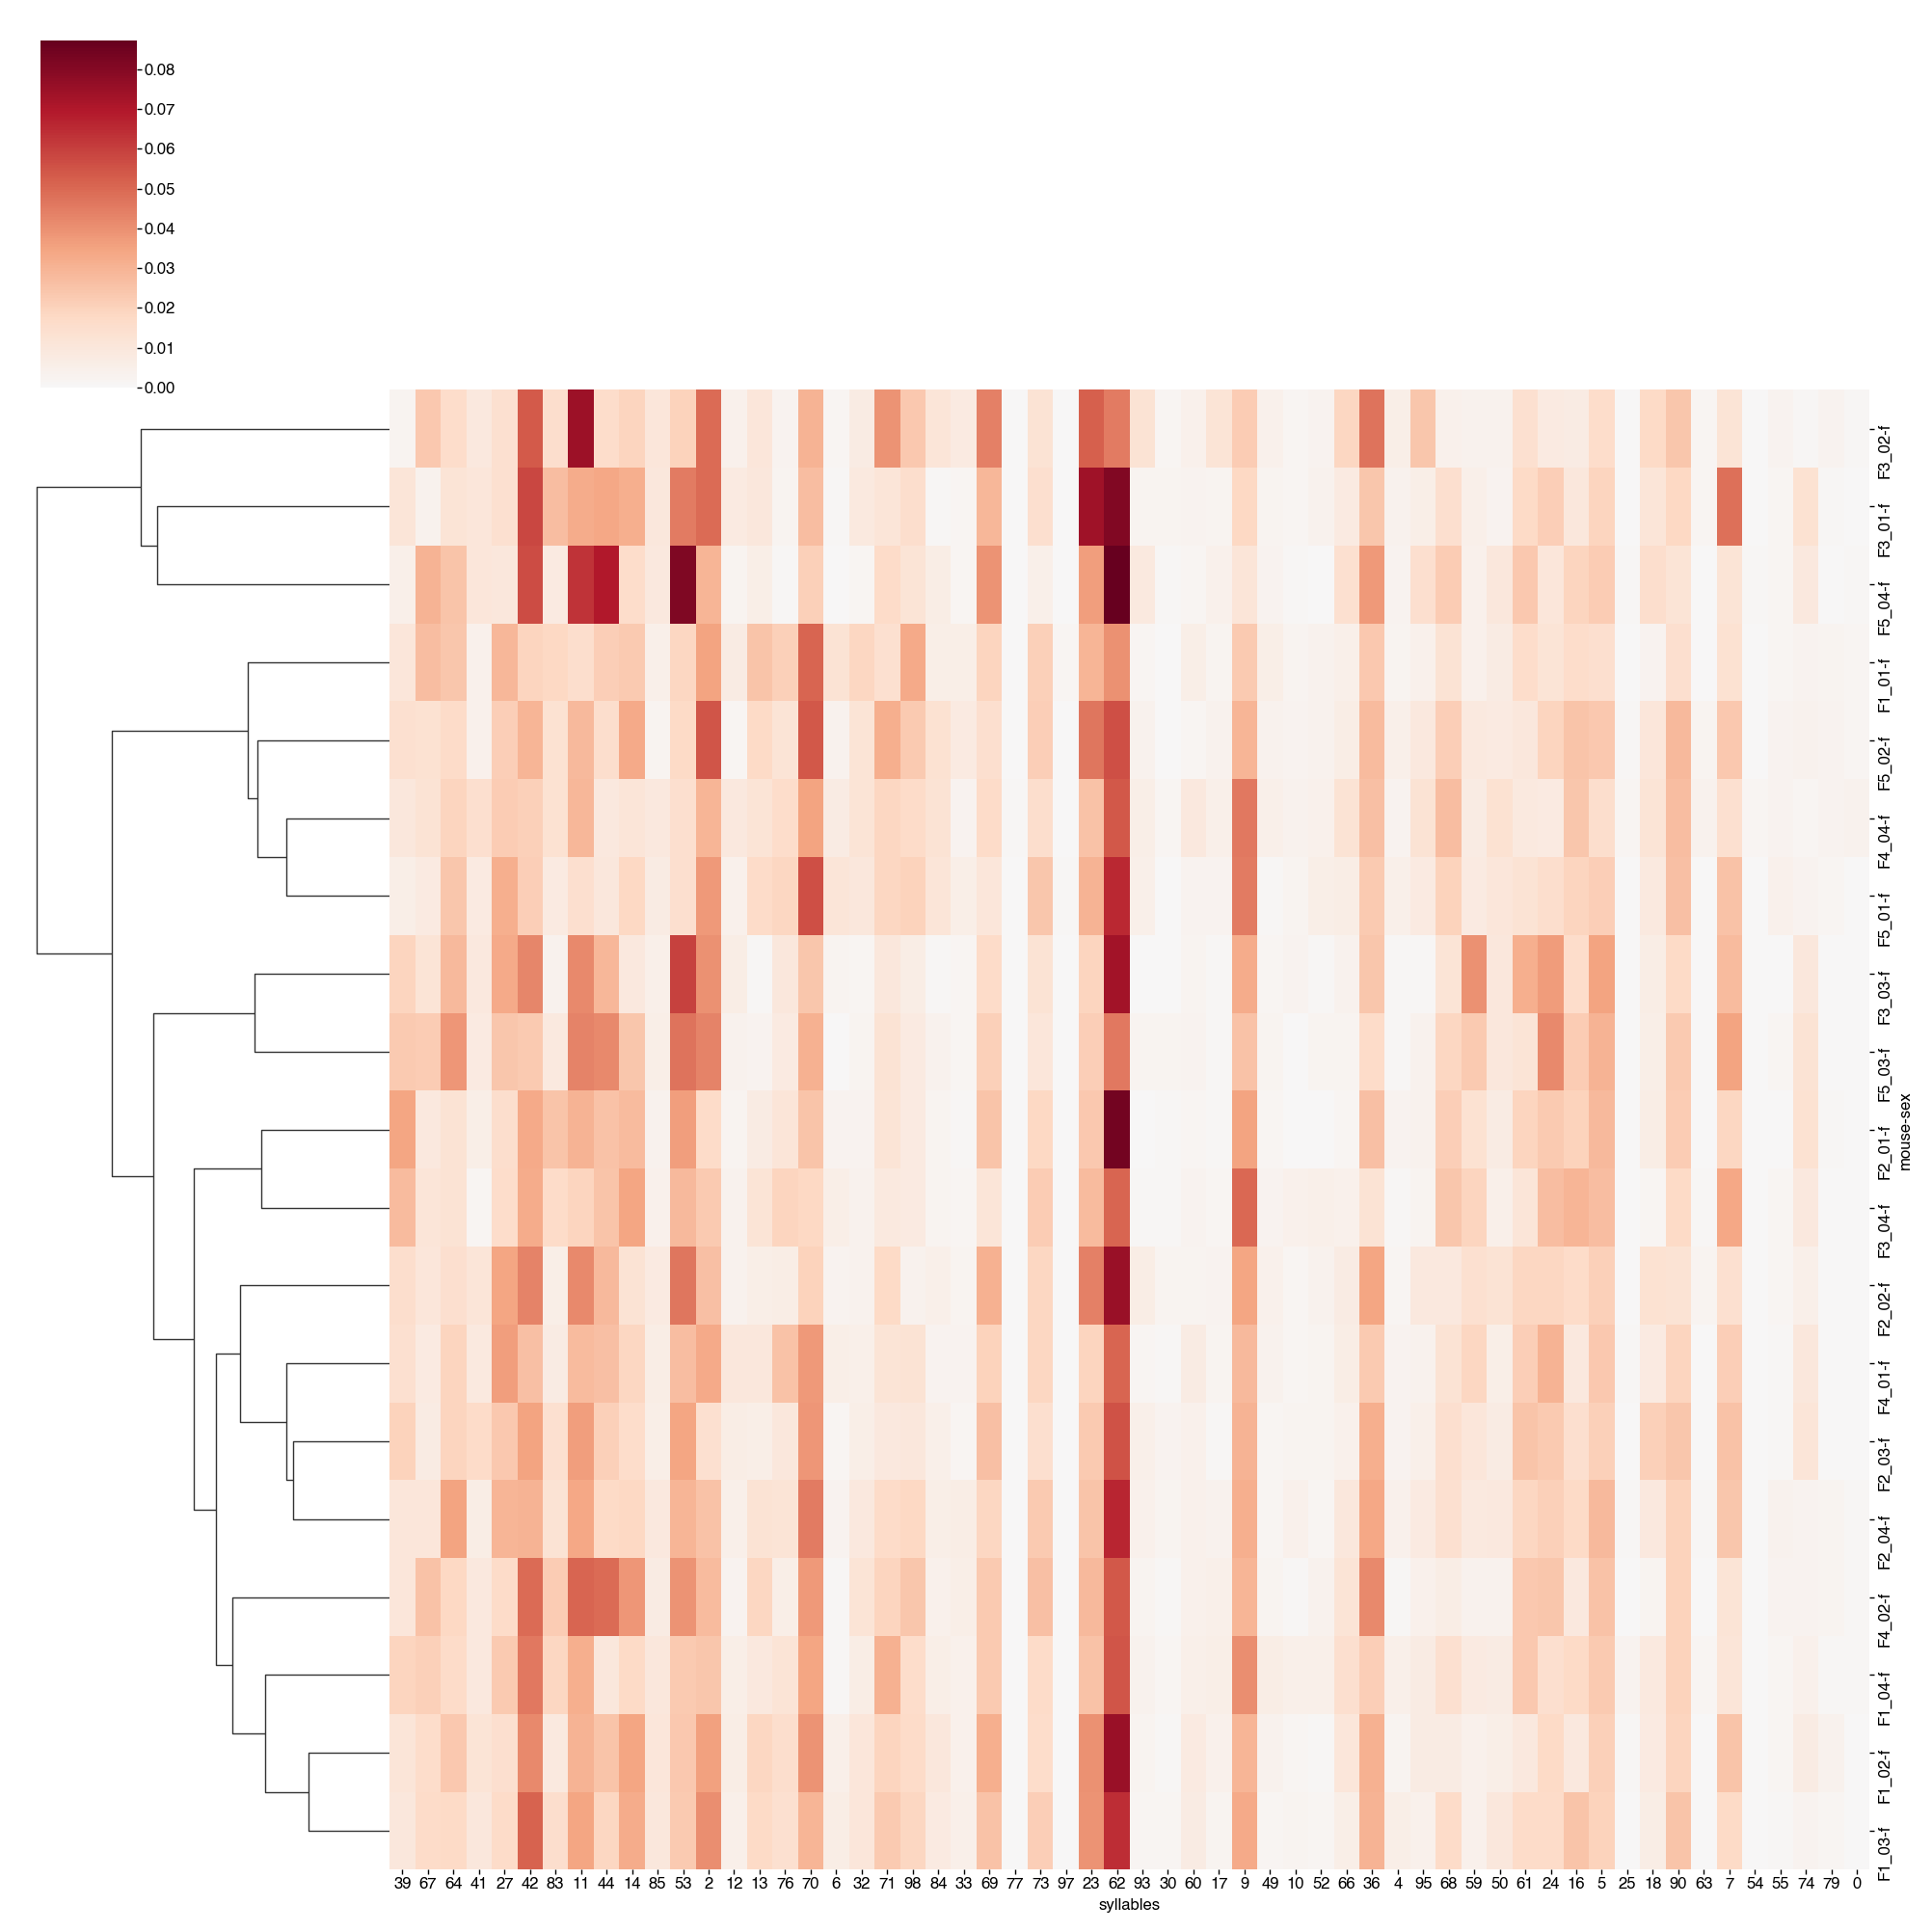

In [26]:
g = sns.clustermap(ba.loc[ind1], cmap='RdBu_r', col_cluster=False, center=0,  metric='euclidean', method='ward')
row_order = g.dendrogram_row.dendrogram['leaves']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


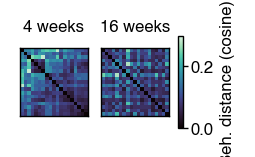

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(1.2, 0.6), sharey=True)
age = syll_df['age'].min()
#out = squareform(pdist(ba.loc[ind1], metric='jensenshannon'))
out = squareform(pdist(ba.loc[ind1].iloc[row_order], metric='cosine'))
ax[0].imshow(out, vmin=0.0, vmax=0.3, cmap='mako')
ax[0].set(xticks=[], yticks=[],title=f"{age} weeks")
age = syll_df['age'].max()
#out = squareform(pdist(ba.loc[ind2],metric='jensenshannon'))
out = squareform(pdist(ba.loc[ind2].iloc[row_order], metric='cosine'))
im=ax[1].imshow(out,vmin=0, vmax=0.3, cmap='mako')
ax[1].set(xticks=[], yticks=[],title=f"{age} weeks")
fig.colorbar(im, ax=ax, label="Beh. distance (cosine)")
legend(ax[1])

In [28]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ '2indv_example_dist_longv2_female_cosine.pdf')